In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdate
import matplotlib.ticker as mtick
import os
%matplotlib inline

* load data, and seperate GMV, Sales, and ATV

In [87]:
def load_data(path,unit = 1, index=None, growpby=None):
    data = pd.read_excel(path, index_col=index)
    data['gmv'] = data['gmv'] / unit
    data['sale_qtty'] = data['sale_qtty'] /unit
    timedata = data.groupby(growpby)
    new_data = timedata.sum()
    gmv = new_data['gmv'].unstack()
    sales = new_data['sale_qtty'].unstack()
    atv = gmv / sales
    return gmv, sales, atv

* load brands or catelog list

In [3]:
def load_cat(path,name):
    brands = pd.read_excel(path).fillna(0)
    brand_lit =brands[name].tolist()
    while 0 in brand_lit:
        brand_lit.remove(0)
    return brand_lit

* plot the data

In [4]:
def line_format(label):
    """
    Convert time label to the format of pandas line plot
    """
    if type(label) == pd.Period:
        label = label.to_timestamp()
    month = label.month_name()[:3] + f"-{str(label.year)[-2:]}"
    return month

def plot(data,cat,kind,stacked = True,xtick = True):
    plt.rcParams['font.family'] = ['sans-serif']
    plt.rcParams['font.sans-serif'] = ['SimHei']
    fig,axes = plt.subplots(figsize = (16,10))
    
    
    data[cat].plot(kind=kind,ax = axes,style = 'o-',colormap='Blues_r',stacked=stacked)
    if xtick:
        axes.set_xticklabels(map(lambda x: line_format(x), data.index))
        plt.xticks(rotation=0)

* calculate the growth

In [142]:
def yoy_growth(df,period):
    tmp = df.to_period(period).groupby('dt').sum()
    tmp1 = tmp['2018']
    tmp2 =tmp['2019']
    growth = tmp2.copy()
    m,n = tmp2.shape
    for i in range(n):
        for j in range(m):
            growth.iloc[j,i] =(tmp2.iloc[j,i]/tmp1.iloc[j,i]-1)
    return growth

In [143]:
def m_growth(df,period):
    tmp = df.to_period(period).groupby('dt').sum()
    growth = tmp.copy()
    m,n = tmp.shape
    for i in range(n):
            growth.iloc[:,i] = (tmp.iloc[:,i]/tmp.iloc[:,i].shift(1) -1)
    return growth

* save datas

In [104]:
def growth_data(catlist,path):
    writer = pd.ExcelWriter(path)
    for cat_name in catlist:
        cat = pd.DataFrame(cat_gmv[cat_name])
        cat['CR'] = cat_gmv_mgrowth[cat_name].fillna(0).tolist()
        cat.to_excel(writer, sheet_name=cat_name)
    writer.save()
    writer.close()

In [156]:
def bubble_data(gmv,date,kind = None,cat_gmv = None,brands = None):
    if kind == "cat":
        data = gmv.loc[date,:]
        total = data.sum()
        gmv_pct = data / total
        gmv_yoy = yoy_growth(gmv,"M").loc[date,:]
    else:
        total = cat_gmv.loc[date,kind]
        data = gmv[brands].loc[date,:]
        gmv_pct = data / total
        gmv_yoy = yoy_growth(gmv,"M")[brands].loc[date,:]
    tmp = pd.DataFrame(gmv_pct)
    tmp.columns = ['平均市场份额']
    tmp["销售额增速"] = np.array(gmv_yoy)
    tmp["销售额"] = np.array(data)
    return tmp

* 运行

In [147]:
unit = 100000000
cat_gmv, cat_sales, cat_atv = load_data('Tmall_cat.xlsx', index='dt', growpby=['dt','cid1_name'],unit = unit)
gmv, sales, atv = load_data('Tmall_brand.xlsx', index='dt', growpby=['dt', 'main_brand_name'],unit=unit)

In [148]:
cat_gmv

cid1_name,其他,医药保健,家居家装,家用电器,手机数码,文化玩乐,服装鞋包,母婴用品,汽车相关,游戏话费,珠宝首饰,生活服务,电脑、办公,百货食品,美妆个护,运动户外,酒类
dt,,,,,,,,,,,,,,,,,
2018-01-01,99.521815,44.655355,192.504481,65.715756,65.998177,11.350217,269.215346,81.653226,19.993304,10.641698,17.456139,11.701685,11.685329,54.237728,28.073865,115.570536,1.728304
2018-02-01,56.738919,24.196296,115.227997,41.813388,39.657827,54.809329,207.230361,46.857993,11.121514,15.386298,12.854494,10.890258,8.691825,22.647875,20.101359,77.797048,0.747652
2018-03-01,272.890173,37.208997,200.646938,51.180978,55.847624,63.734450,169.448510,75.981523,16.760497,11.048622,18.709066,15.816968,12.264568,34.860845,33.369578,98.680932,0.889899
2018-04-01,90.520250,36.212096,228.005189,59.390675,47.225761,17.607895,149.283456,71.593454,17.191647,7.698437,24.940212,14.142878,11.193424,36.137652,26.334516,123.021542,0.797776
2018-05-01,201.742679,38.438646,244.466008,72.478624,47.828380,23.748054,148.446095,75.978467,18.071275,7.355190,31.249728,14.075934,12.588563,41.200212,27.161170,135.619906,0.868571
2018-06-01,50.385214,50.191777,310.676739,166.278289,117.306567,24.515519,269.440231,94.841837,39.558623,110.173648,389.790876,36.671491,40.141643,81.839733,90.839091,77.440972,6.059877
2018-07-01,40.619427,44.038786,245.375168,134.985897,96.078547,17.896350,205.765049,68.895395,34.255267,111.191632,336.332535,353.173781,35.776138,66.767027,57.270119,59.353770,3.609187
2018-08-01,48.379234,47.231852,628.713186,117.910718,119.191867,17.842106,208.916652,79.841658,34.656333,111.941000,411.374374,353.961673,37.217772,84.164011,73.213210,59.085880,4.641267
2018-09-01,52.853274,51.306107,647.168874,125.598195,115.606245,20.308379,278.797039,105.118074,38.367810,115.394254,320.005761,35.364427,37.836597,99.765664,81.090087,68.170934,7.381060


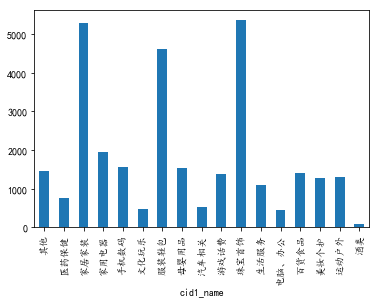

In [149]:
cat_gmv.sum(axis=0).plot(kind = 'bar')

In [150]:
cat_gmv_yoy = yoy_growth(cat_gmv,"M")
cat_gmv_yoy


cid1_name,其他,医药保健,家居家装,家用电器,手机数码,文化玩乐,服装鞋包,母婴用品,汽车相关,游戏话费,珠宝首饰,生活服务,电脑、办公,百货食品,美妆个护,运动户外,酒类
dt,,,,,,,,,,,,,,,,,
2019-01,-0.538423,0.067987,0.411427,0.881420,0.783374,1.371778,0.426578,0.240561,1.283393,11.517597,25.200207,0.669000,1.738095,1.398450,1.842530,-0.565151,9.023628
2019-02,-0.320778,0.939444,0.810174,1.980875,1.696331,-0.443599,-0.043243,0.804267,1.957655,7.722311,36.960451,1.975979,3.338295,2.098656,4.070102,-0.298064,4.352282
2019-03,-0.773300,0.581317,0.778301,1.752166,1.119860,-0.267235,0.565385,0.254405,1.047268,10.688132,15.900508,1.832704,2.555803,1.657856,2.588919,-0.259718,4.080038
2019-04,-0.259971,0.680057,0.337028,1.680753,1.920485,1.365843,1.126321,0.596038,1.220737,15.360238,12.342702,2.275221,1.294231,5.060695,5.264553,-0.376783,5.039933


In [106]:
catlist = ['医药保健','酒类','家用电器','美妆个护','服装鞋包']
growth_data(catlist,'cat_test.xlsx')

In [157]:
date = '2019-04-01'
catlist = ['医药保健','酒类','家用电器','美妆个护','服装鞋包']
writer = pd.ExcelWriter('cat_bubble.xlsx')
for kind in catlist:
    
    brands = load_cat('brand_catalog.xlsx',kind)
    b_brand = bubble_data(gmv,date,kind = kind,cat_gmv = cat_gmv,brands = brands)
    b_brand.to_excel(writer,sheet_name=kind)
writer.save()
writer.close()

D:\anaconda\envs\dataServer\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


In [138]:
cat_gmv_mgrowth = m_growth(cat_gmv,"M")
cat_gmv_mgrowth

cid1_name,其他,医药保健,家居家装,家用电器,手机数码,文化玩乐,服装鞋包,母婴用品,汽车相关,游戏话费,珠宝首饰,生活服务,电脑、办公,百货食品,美妆个护,运动户外,酒类
dt,,,,,,,,,,,,,,,,,
2018-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,-42.988460,-45.815465,-40.142694,-36.372355,-39.910723,382.892363,-23.024313,-42.613421,-44.373806,44.584986,-26.361189,-6.934270,-25.617627,-58.243319,-28.398320,-32.684359,-56.740706
2018-03,380.957652,53.779722,74.130371,22.403328,40.823711,16.283944,-18.231813,62.152748,50.703375,-28.191806,45.544949,45.239604,41.104645,53.925454,66.006575,26.844058,19.025802
2018-04,-66.829055,-2.679193,13.635020,16.040523,-15.438191,-72.373033,-11.900402,-5.775179,2.572419,-30.322200,33.305489,-10.584144,-8.733648,3.662583,-21.082262,24.665971,-10.352059
2018-05,122.870219,6.148635,7.219493,22.037043,1.276038,34.871626,-0.560920,6.124879,5.116599,-4.458664,25.298566,-0.473339,12.463917,14.009101,3.139049,10.240779,8.874068
2018-06,-75.025010,30.576342,27.083819,129.417007,145.265611,3.231693,81.507119,24.827259,118.903334,1397.903577,1147.341653,160.526166,218.873897,98.639105,234.444694,-42.898522,597.683257
2018-07,-19.382248,-12.258962,-21.019138,-18.819289,-18.096191,-26.999912,-23.632396,-27.357591,-13.406320,0.923982,-13.714621,863.074519,-10.875251,-18.417345,-36.954324,-23.356115,-40.441253
2018-08,19.103685,7.250576,156.225270,-12.649602,24.056691,-0.303099,1.531652,15.888236,1.170814,0.673942,22.311799,0.223089,4.029596,26.056250,27.838411,-0.451344,28.595923
2018-09,9.247852,8.626075,2.935470,6.519744,-3.008277,13.822765,33.448931,31.658180,10.709376,3.084887,-22.210575,-90.008967,1.662713,18.537203,10.758819,15.376015,59.031144


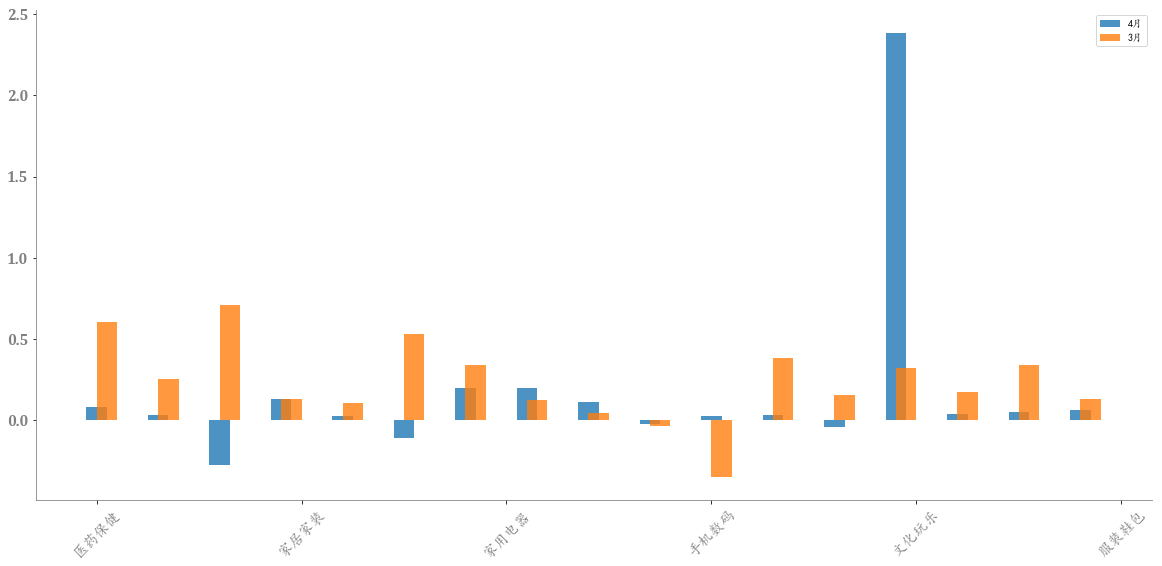

In [109]:
fig, ax1 = plt.subplots(figsize = (20,9))

x_tic = cat_gmv_mgrowth.columns.tolist()
x = [i*3 for i in range(len(x_tic))]
bar_1 = ax1.bar(x,cat_gmv_mgrowth.iloc[-1,:],width = 1, alpha = 0.8,label = '4月')
bar_2 = ax1.bar([i + 0.5 for i in x],cat_gmv_mgrowth.iloc[-2,:],width = 1, alpha =0.8,label = '3月')
ax1.set_xticklabels(x_tic,rotation=45,fontsize = 15,color = 'gray')

ax1.spines['top'].set_visible(False)  # 去掉上边框
ax1.spines['right'].set_visible(False)  # 去掉上边框

ax1.spines['bottom'].set_color('gray')
ax1.spines['left'].set_color('gray')


plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['KaiTi']
plt.yticks(fontproperties = 'Cambria', size = 15,color = 'gray')
plt.xticks(size = 15,color = 'gray',rotation = 45)
plt.legend()

In [94]:
def plot_CR(cat_name):
    '''GMV和环比增速
    '''
    fig, ax1 = plt.subplots(figsize = (20,9))
    cat_gmv[cat_name].plot(kind = 'bar',ax = ax1,color = '#002060')
    plt.yticks(fontproperties = 'Cambria', size = 15,color = 'gray')
    ax2 = ax1.twinx()  # 实例化一个新的坐标轴，共享同一个x轴
    ax2.plot(cat_gmv_mgrowth[cat_name].tolist(),color = '#C00000',linewidth = 3)
    ax1.set_xticklabels(map(lambda x: line_format(x), cat_gmv.index),rotation=45,fontsize = 15,color = 'gray')

    ax1.spines['top'].set_visible(False)  # 去掉上边框
    ax1.spines['right'].set_visible(False)  # 去掉上边框
    ax2.spines['top'].set_visible(False)  # 去掉上边框
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)  # 去掉上边框

    ax1.spines['bottom'].set_color('gray')
    ax1.spines['left'].set_color('gray')
    ax2.spines['right'].set_color('gray')
    
    fmt_y = '%2.2f%%'
    y_ticks = mtick.FormatStrFormatter(fmt_y)
    ax2.yaxis.set_major_formatter(y_ticks)

    plt.rcParams['font.family'] = ['sans-serif']
    plt.rcParams['font.sans-serif'] = ['KaiTi']
    plt.yticks(fontproperties = 'Cambria', size = 15,color = 'gray')

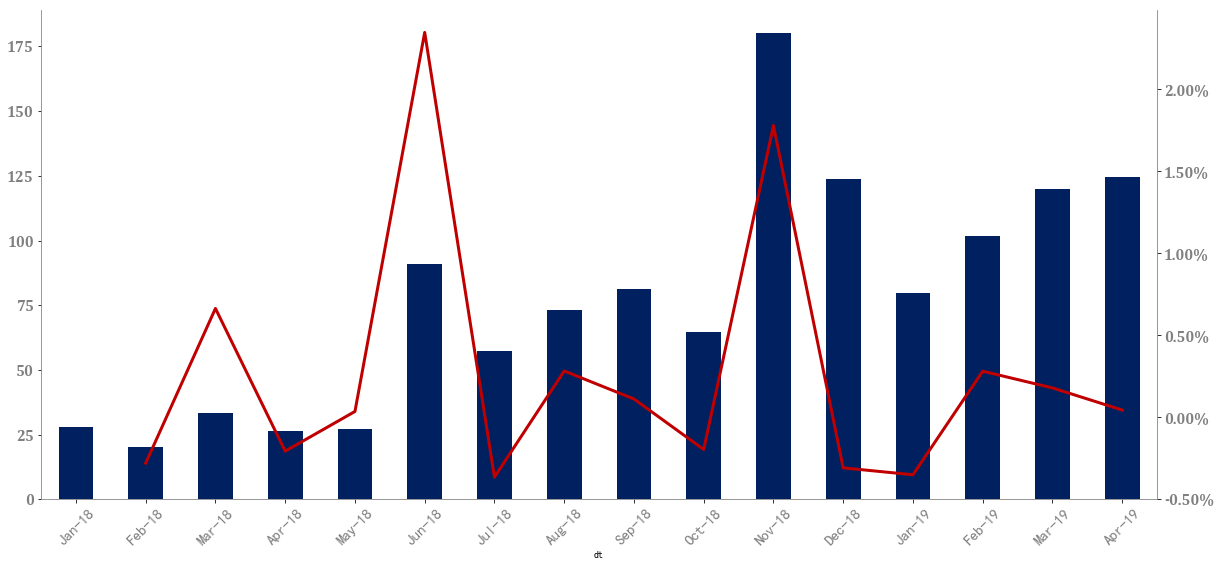

In [95]:
plot_CR('美妆个护')

In [12]:
farm = load_cat('brand_catalog.xlsx','美妆个护')
farm

['一叶子', '佰草集', '兰蔻', '御泥坊', '欧莱雅', '珀莱雅', '百雀羚', '自然堂', '雅诗兰黛', '雪花秀', '韩束']

In [146]:
date = '2019-04-01'
cat = bubble_data(cat_gmv,date,kind = 'cat',cat_gmv = None,brands = None)
cat = cat.sort_values(by = '销售额',ascending=False)
cat.to_excel('Tcat.xlsx')

In [16]:
cat.sort_values(by = '销售额')

,市场份额,销售额增速,销售额
cid1_name,,,
酒类,0.002153,5.039933,481851423
汽车相关,0.017063,1.220737,3817813347
文化玩乐,0.018618,1.365843,4165752129
电脑、办公,0.018737,2.745542,4192544335
生活服务,0.020702,2.275221,4632104484
医药保健,0.027194,0.680307,6084744183
其他,0.029934,-0.260071,6697855715
运动户外,0.034265,-0.376783,7666909955
母婴用品,0.051068,0.596038,11426586190


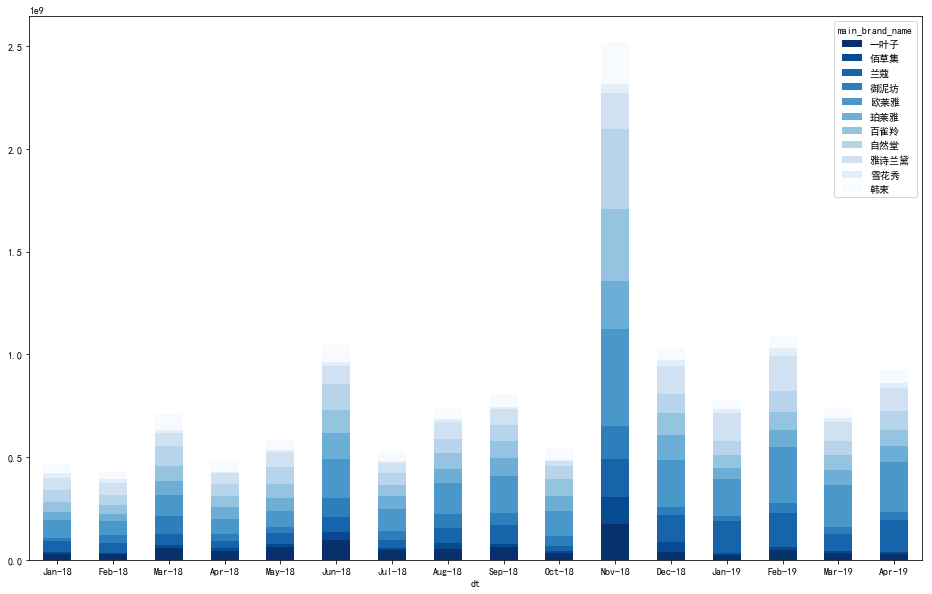

In [173]:
plot(gmv,farm,'bar')

In [11]:
gmv_growth = yoy_growth(gmv,'M')
gmv_growth

D:\anaconda\envs\dataServer\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


main_brand_name,Blackmores,GNC,H&M,TCL,Zara,一叶子,九阳,五粮液,优衣库,佰草集,...,自然堂,苏泊尔,茅台,资生堂,酒鬼,阿迪达斯,雅诗兰黛,雪花秀,韩束,飞科
dt,,,,,,,,,,,,,,,,,,,,,
2019-01,-0.283499,0.529921,inf,0.438528,0.611502,-0.130777,0.508573,9.956918,0.543475,-0.239165,...,0.248098,0.622903,8.821162,0.283606,10.923182,-0.029710,1.212482,-0.128207,-0.141034,0.486877
2019-02,1.794414,2.268188,8368.557470,1.302303,2.432081,0.705502,1.563049,3.924775,2.161133,1.614723,...,1.118665,2.384273,9.522258,1.865905,13.352025,1.040702,1.910882,1.231228,0.632860,0.869649
2019-03,0.535117,1.205354,136.806353,1.202460,0.190844,-0.447761,1.054756,9.470088,0.586173,-0.266086,...,-0.332459,1.491019,10.637858,0.679151,11.340905,0.163749,0.467254,0.281478,-0.234306,0.487294
2019-04,1.902742,1.724927,2.654139,1.384974,0.714291,-0.380093,1.053761,8.214103,1.008005,0.016305,...,0.663226,1.176167,8.697592,1.585088,14.051704,0.665126,1.116024,1.794916,0.300075,0.619142


In [135]:
tmp = bubble_data(gmv,'2019-04-01',kind = "美妆个护",cat_gmv = cat_gmv,brands = farm)
tmp

D:\anaconda\envs\dataServer\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


,市场份额,销售额增速,销售额
main_brand_name,,,
一叶子,0.002220,-0.380093,27658738.0
佰草集,0.000978,0.016305,12185959.0
兰蔻,0.012241,3.387686,152484665.0
御泥坊,0.003126,0.166714,38946679.0
欧莱雅,0.019447,2.342729,242253277.0
珀莱雅,0.006420,0.353988,79979311.0
百雀羚,0.006171,0.381459,76877704.0
自然堂,0.007564,0.663226,94227356.0
雅诗兰黛,0.009109,1.116024,113467979.0


In [122]:
cat_gmv.loc['2019-04-01',’

cid1_name
其他        6697855715
医药保健      6084744183
家居家装     25902852729
家用电器     15921170404
手机数码     12167697546
文化玩乐      4165752129
服装鞋包     31742451718
母婴用品     11426586190
汽车相关      3817813347
游戏话费     12594826321
珠宝首饰     32428399756
生活服务      4632104484
电脑、办公     4192544335
百货食品     31372911284
美妆个护     12457083725
运动户外      7666909955
酒类         481851423
Name: 2019-04-01 00:00:00, dtype: int64

In [107]:
gmv_growth1 = yoy_growth(cat_gmv,'M')
tmp = gmv_growth1.T['2019-04-01']
tmp.shape

(17,)

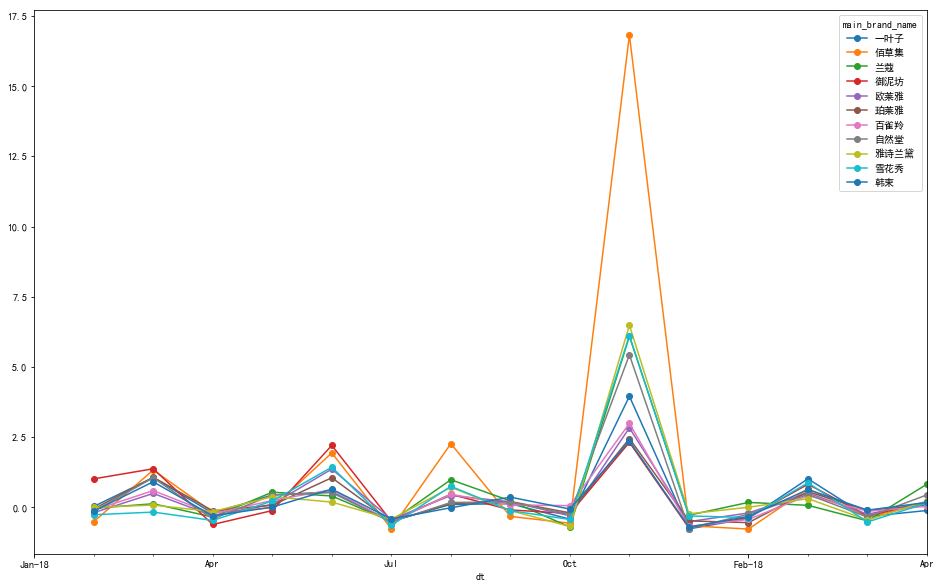

In [176]:
plot(gmv_growth1,farm,'line',stacked = False)